In [168]:
import json
import gzip
import math
import string
import random
import statistics
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn import metrics
from sklearn import linear_model
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
def assertFloat(x):
    assert type(float(x)) == float

def assertFloatList(items, N):
    assert len(items) == N
    assert [type(float(x)) for x in items] == [float]*N

# Load Data

In [4]:
#z = gzip.open("qa_Electronics.json.gz")

In [5]:
#dataset = []
#for l in z:
#    d = eval(l)
#    dataset.append(d)

In [6]:
'''data = []
for entry in dataset:
    for question in entry['questions']:
        data.append({
            'asin': entry['asin'],
            'questionText': question['questionText'],
            'numAnswers': len(question['answers'])
        })
'''
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

data = getDF('QA_Electronics.json.gz')

In [7]:
#data[0]
data.head(1)

,asin,questions
0,1400599997,"[{'questionType': 'yes/no', 'askerID': 'A1KP1T..."


In [8]:
import pandas as pd


flattened_data = []

for index, row in data.iterrows():
    asin = row['asin']
    questions = row['questions']

    for question in questions:
        question_type = question.get('questionType', None)
        question_text = question.get('questionText', None)
        asker_id = question.get('askerID', None)
        question_time = question.get('questionTime', None)
        answers = question.get('answers', [])

        for answer in answers:
            answer_text = answer.get('answerText', None)
            answerer_id = answer.get('answererID', None)
            answer_time = answer.get('answerTime', None)
            helpful = answer.get('helpful', [0, 0])
            answer_type = answer.get('answerType', None)
            answer_score = answer.get('answerScore', None)

            flattened_data.append({
                'asin': asin,
                'question_type': question_type,
                'question_text': question_text,
                'asker_id': asker_id,
                'question_time': question_time,
                'answer_text': answer_text,
                'answerer_id': answerer_id,
                'answer_time': answer_time,
                'helpful_upvotes': helpful[0],
                'helpful_total': helpful[1],
                'answer_type': answer_type,
                'answer_score': answer_score,
            })

data_updated = pd.DataFrame(flattened_data)
data_updated['numAnswers'] = data_updated.groupby('question_text')['answer_text'].transform('count')


#print(data_updated.head())
print(data_updated[data_updated['question_text']=='is it user friendly'])

         asin question_type        question_text        asker_id  \
0  1400599997        yes/no  is it user friendly  A1KP1TT2M38V8P   
1  1400599997        yes/no  is it user friendly  A1KP1TT2M38V8P   
2  1400599997        yes/no  is it user friendly  A1KP1TT2M38V8P   
3  1400599997        yes/no  is it user friendly  A1KP1TT2M38V8P   
4  1400599997        yes/no  is it user friendly  A1KP1TT2M38V8P   
5  1400599997        yes/no  is it user friendly  A1KP1TT2M38V8P   

   question_time                                        answer_text  \
0  June 27, 2013            Very much. Both my 9&4yr old csn use it   
1  June 27, 2013  I have the nook 1st edition and it is very use...   
2  June 27, 2013  It is pretty user friendly/ self explanatory. ...   
3  June 27, 2013  Yes, it's pretty simply and standard functiona...   
4  June 27, 2013  I like the nook. I'm a reading fanatic and I'v...   
5  June 27, 2013  I bought it as a gift so I don't know about th...   

      answerer_id    answ

In [101]:
data_updated['question_time']
data_updated['question_text'] = data_updated['question_text'].str.lower()

In [107]:
data_updated = pd.DataFrame(flattened_data)
data_updated['question_text'] = data_updated['question_text'].str.lower()
data_updated['numAnswers'] = data_updated.groupby('question_text')['answer_text'].transform('count')

In [109]:
temp = data_updated.drop_duplicates(subset=['question_text'],inplace=False)

value_counts = temp['numAnswers'].value_counts()

for num, count in sorted(value_counts.items()):
    print(f'{num}: {count}')

1: 1670
2: 61909
3: 50768
4: 37329
5: 23469
6: 15100
7: 8093
8: 5073
9: 2862
10: 4289
11: 230
12: 612
13: 163
14: 229
15: 215
16: 216
17: 74
18: 174
19: 56
20: 250
21: 77
22: 36
23: 27
24: 87
25: 45
26: 22
27: 34
28: 38
29: 12
30: 79
31: 7
32: 33
33: 10
34: 13
35: 24
36: 20
37: 3
38: 6
39: 12
40: 46
41: 8
42: 19
43: 3
44: 7
45: 9
46: 8
47: 4
48: 9
49: 6
50: 12
51: 2
52: 4
53: 1
54: 4
55: 3
56: 7
57: 3
58: 1
59: 2
60: 14
61: 1
62: 4
63: 2
64: 2
65: 2
66: 4
67: 2
68: 2
69: 1
70: 3
71: 2
72: 4
73: 1
74: 2
76: 2
77: 2
78: 1
79: 1
80: 4
81: 2
82: 3
84: 4
85: 1
86: 2
87: 1
89: 1
91: 3
93: 1
96: 2
97: 2
98: 1
100: 1
102: 2
104: 1
108: 1
110: 1
114: 1
118: 2
120: 3
126: 4
127: 2
129: 1
133: 1
135: 1
137: 1
140: 2
143: 1
144: 2
150: 1
152: 1
183: 1
185: 1
194: 1
258: 1
260: 1
276: 1
747: 1


In [111]:
sum(value_counts)

213639

# Get Top 5

In [114]:
top5 = temp.nlargest(5, 'numAnswers')[['question_text', 'answer_text', 'numAnswers']]
top5

,question_text,answer_text,numAnswers
2563,how long is the cord?,Apromx. 11 ft.,747
11565,how long is the cable?,It's about 6 feet long... I also bought the ex...,276
21992,does it have bluetooth?,yes.,260
16714,what are the dimensions?,14.75 x 6.75 x 1,258
12443,is it waterproof?,Its waterproof as far as being made for the tr...,194


# Look At Answer Counts

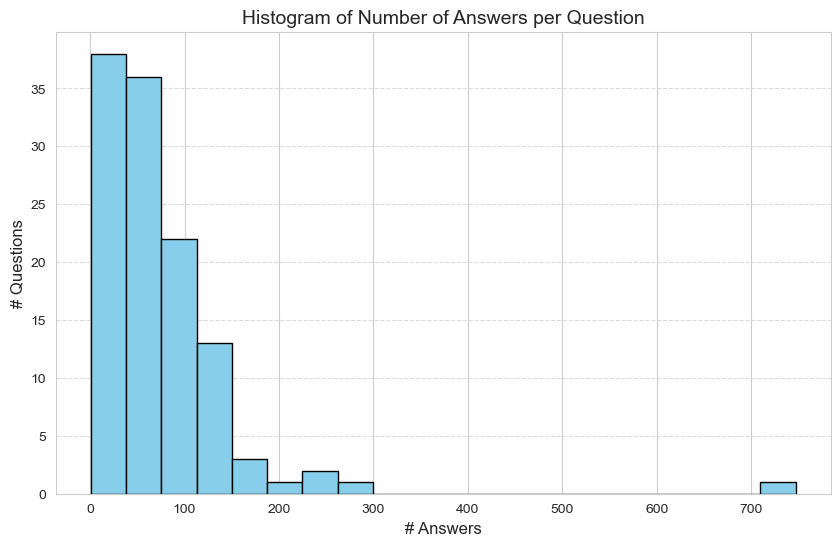

In [117]:
'''plt.hist(numAnswers, bins = 10)
plt.title('Histogram of Answer counts', size = 15, fontweight = 'bold')
plt.show()
'''
a=[]
for num, count in sorted(value_counts.items()):
    a.append(num)

plt.figure(figsize=(10, 6))
plt.hist(a, bins=20, edgecolor='black', color='skyblue')
plt.xlabel('# Answers', fontsize=12)
plt.ylabel('# Questions', fontsize=12)
plt.title('Histogram of Number of Answers per Question', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [118]:
#n = len(data)
#n_train = int(n * 0.8)

'''
sia = SentimentIntensityAnalyzer()

def feat(datum):
    """Extract features: bias term and sentiment polarity score."""
    return [1, sia.polarity_scores(datum['question'])['compound']]


X = df.apply(feat, axis=1).tolist()
y = df['numAnswers'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


mod1 = LinearRegression()
mod1.fit(X_train, y_train)
pred1 = mod1.predict(X_test)

mse1 = metrics.mean_squared_error(y_test, pred1)
print(f"MSE: {mse1}")
'''

'\nsia = SentimentIntensityAnalyzer()\n\ndef feat(datum):\n    """Extract features: bias term and sentiment polarity score."""\n    return [1, sia.polarity_scores(datum[\'question\'])[\'compound\']]\n\n\nX = df.apply(feat, axis=1).tolist()\ny = df[\'numAnswers\'].tolist()\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n\nmod1 = LinearRegression()\nmod1.fit(X_train, y_train)\npred1 = mod1.predict(X_test)\n\nmse1 = metrics.mean_squared_error(y_test, pred1)\nprint(f"MSE: {mse1}")\n'

# Baseline: Question Length

In [122]:
def MSE(y, ypred):
    return metrics.mean_squared_error(y, ypred)

def feat(datum):
    return [1, len(datum['question_text'])]

In [124]:
X = temp.apply(feat, axis=1).tolist()
y = temp['numAnswers'].tolist()

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)

In [126]:
mod = linear_model.LinearRegression(fit_intercept = False)
mod.fit(X_train, y_train)
pred = mod.predict(X_test)

In [127]:
mse = MSE(y_test, pred)
mse

14.468939657279837

# Random Model

In [129]:
min_val, max_val = min(y_train), max(y_train)
random_pred = np.random.uniform(min_val, max_val, len(y_test))
baseline_mse = MSE(y_test, random_pred)
baseline_mse

183308.5917789191

# Fit Sentiment

In [134]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/totototoro/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [137]:
sia = SentimentIntensityAnalyzer()

def feat1(datum):
    feature = feat(datum)
    return feature + [sia.polarity_scores(datum['question_text'])['compound']]

In [140]:
#X1 = [feat(d) for d in data]
#y = [d['numAnswers'] for d in data]
X1 = temp.apply(feat1, axis=1).tolist()

In [141]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y,test_size = 0.2, random_state = 10)

In [142]:
mod1 = linear_model.LinearRegression(fit_intercept = False)
mod1.fit(X1_train, y_train)
pred1 = mod1.predict(X1_test)

In [143]:
mse1 = MSE(y_test, pred1)
mse1

14.468509481211926

# Data Transformation

In [145]:
X1_log = [[np.log(x) if x > 0 else 0 for x in row] for row in X1] 
X1_log1p = [[np.log1p(x) if x > 0 else 0 for x in row] for row in X1] 
X1_2 = [[x ** 2 for x in row] for row in X1]

X1_log_train, X1_log_test = train_test_split(X1_log, test_size=0.2, random_state = 10)
X1_log1p_train, X1_log1p_test = train_test_split(X1_log1p, test_size=0.2, random_state = 10)
X1_2_train, X1_2_test = train_test_split(X1_2, test_size=0.2, random_state = 10)

mod1_log = linear_model.LinearRegression(fit_intercept=False)
mod1_log1p = linear_model.LinearRegression(fit_intercept=False)
mod1_squared = linear_model.LinearRegression(fit_intercept=False)

mod1_log.fit(X1_log_train, y_train)
mod1_log1p.fit(X1_log1p_train, y_train)
mod1_squared.fit(X1_2_train, y_train)

pred1_log = mod1_log.predict(X1_log_test)
pred1_log1p = mod1_log1p.predict(X1_log1p_test)
pred1_2 = mod1_squared.predict(X1_2_test)

mse1_log = MSE(y_test, pred1_log)
mse1_log1p = MSE(y_test, pred1_log1p)
mse1_2 = MSE(y_test, pred1_2)

print(mse1_log)
print(mse1_log1p)
print(mse1_2)

15.034597992010955
14.510844471568618
14.488484067931365


# Hyperparameter Tuning w/ LogisticRegression

C = [0.001, 0.01, 0.1, 1, 10, 100]

best_mse = float('inf')
best_c = None

for c in C:
    mod_tune1 = linear_model.LogisticRegression(fit_intercept = False)
    mod_tune1.fit(X1_train, y_train)
    pred_tune1 = mod_tune1.predict(X1_test)
    mse_tune1 = MSE(y_test, pred_tune1)
    if mse_tune1 < best_mse:
        best_mse = mse_tune1
        best_c = c

print('mse: %s, c = %s' % (best_mse, best_c))

# Fit TFIDF

In [150]:
questionText1 = temp['question_text'].tolist()#[d['questionText'] for d in data]
vectorizer1 = TfidfVectorizer()
X2 = vectorizer1.fit_transform(questionText1)

In [151]:
##X2 = np.hstack([np.ones((X2.shape[0], 1)), X2])

from scipy.sparse import csr_matrix, hstack

ones_column_sparse = csr_matrix(np.ones((X2.shape[0], 1)))
X2_with_ones_sparse = hstack([ones_column_sparse, X2])
print(X2_with_ones_sparse.shape)

(213639, 60998)


In [152]:
X2train, X2test, ytrain, ytest = train_test_split(X2_with_ones_sparse, y, random_state = 10)

In [153]:
mod2 = linear_model.LinearRegression(fit_intercept = False)
mod2.fit(X2train, ytrain)
pred2 = mod2.predict(X2test)

In [154]:
mse2 = MSE(ytest, pred2)
mse2

20.024472425154265

# TFIDF + Remove Punctuation

In [156]:
punct = set(string.punctuation)

def preprocess_text(text):
    return ''.join([c for c in text.lower() if c not in punct])

In [157]:
questionText2 = temp['question_text'].tolist() #[preprocess_text(d['questionText']) for d in data]

vectorizer2 = TfidfVectorizer()
X3 = vectorizer2.fit_transform(questionText2)#.toarray()

In [158]:
from scipy.sparse import csr_matrix, hstack

ones_column_sparse = csr_matrix(np.ones((X3.shape[0], 1)))
X3_with_ones_sparse = hstack([ones_column_sparse, X3])
print(X3_with_ones_sparse.shape)
#X3 = np.hstack([np.ones((X3.shape[0], 1)), X3])

(213639, 60998)


In [159]:
X3train, X3test, ytrain, ytest = train_test_split(X3_with_ones_sparse, y, random_state = 10)

In [160]:
mod3 = linear_model.LinearRegression(fit_intercept = False)
mod3.fit(X3train, ytrain)
pred3 = mod3.predict(X3test)

In [161]:
mse3 = MSE(ytest, pred3)
mse3

20.024472425154265

# TFIDF + Remove Punctuation + Remove stopwords

In [170]:
stopwords = set(stopwords.words('english'))

def preprocess_text(text):
    ws = ''.join([c for c in text.lower() if c not in punct]).split()
    return ' '.join([w for w in ws if w not in stopwords])

In [172]:
questionText3 = temp['question_text'].tolist() #[preprocess_text(d['questionText']) for d in data]

vectorizer3 = TfidfVectorizer()
X4 = vectorizer3.fit_transform(questionText3)#.toarray()

In [173]:
ones_column_sparse = csr_matrix(np.ones((X4.shape[0], 1)))
X4_with_ones_sparse = hstack([ones_column_sparse, X4])
print(X4_with_ones_sparse.shape)

(213639, 60998)


In [174]:
X4train, X4test, ytrain, ytest = train_test_split(X4_with_ones_sparse, y, random_state = 10)

In [175]:
mod4 = linear_model.LinearRegression(fit_intercept = False)
mod4.fit(X4train, ytrain)
pred4 = mod4.predict(X4test)

In [176]:
mse4 = MSE(ytest, pred4)
mse4

20.024472425154265